In [9]:
# !pip install -U scikit-learn

# !pip install seaborn
# !pip install torch
# !pip install torchvision


In [1]:
import os, time, copy, random, hashlib
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import numpy as np
import torch, torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.amp import autocast, GradScaler

from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:
# Configuration
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# check pytorch version

print(torch.__version__)
# ⚙️ Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.7.1+cu126
cuda


In [3]:
#  Step 1: Prepare the Data
dataset_path = r"D:\Internship(sujesh)\PlantVillage"
img_size = 224
# Hyperparams
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])



In [4]:
def count_duplicates(folder_path):
    hashes = defaultdict(list)
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif")):
                path = os.path.join(root, file)
                with open(path, "rb") as f:
                    h = hashlib.md5(f.read()).hexdigest()
                hashes[h].append(path)

    duplicates = {k: v for k, v in hashes.items() if len(v) > 1}
    total = sum(len(v) for v in duplicates.values())
    print(f"🔁 Duplicate groups: {len(duplicates)}")
    print(f"📸 Total duplicate images (including originals): {total}")
    print(f"⚠️ Redundant images to remove: {total - len(duplicates)}")

# ✅ Example usage
count_duplicates(r"D:\Internship(sujesh)\PlantVillage")

# def remove_duplicate_images(folder_path):
#     hash_map = defaultdict(list)
#     for root, _, files in os.walk(folder_path):
#         for fname in files:
#             if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif")):
#                 path = os.path.join(root, fname)
#                 try:
#                     with open(path, "rb") as f:
#                         h = hashlib.md5(f.read()).hexdigest()
#                     hash_map[h].append(path)
#                 except Exception as e:
#                     print(f"❌ Error reading {path}: {e}")
#     removed = []
#     for group in hash_map.values():
#         for dup in group[1:]:
#             try:
#                 os.remove(dup)
#                 removed.append(dup)
#             except Exception as e:
#                 print(f"⚠️ Could not delete {dup}: {e}")
#     print(f"✅ Removed {len(removed)} duplicate images.")
#     return removed

# remove_duplicate_images(dataset_path)





🔁 Duplicate groups: 0
📸 Total duplicate images (including originals): 0
⚠️ Redundant images to remove: 0


In [5]:
# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.best_model = None
        self.stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

In [6]:
from torch.utils.data import random_split
from torch.utils.data import Subset


# Split into training and validation sets

full_ds = datasets.ImageFolder(dataset_path, transform=train_tfms)

train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_dataset, val_dataset = random_split(full_ds, [train_size, val_size])




# Assuming you've already defined `full_ds`
train_indices = list(range(0, int(0.8 * len(full_ds))))  # or use train_idx from K-Fold
train_subset = Subset(full_ds, train_indices)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



img, label = full_ds[0]
print(type(img), img.shape)
print(type(label), label)

# batch = next(iter(train_loader))
# for batch in train_loader:
#     print(len(batch))
#     print(type(batch))
#     print(batch)
#     break




<class 'torch.Tensor'> torch.Size([3, 224, 224])
<class 'int'> 0


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Step 1: Setup Device
# ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Define the Model
# ========================
class AlexNet(nn.Module):
    def __init__(self, num_classes=15):
        super(AlexNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Safely determine the flatten dimension using current model's device
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224).to(next(self.parameters()).device)
            x = self.layer1(dummy)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.layer5(x)
            x = self.layer6(x)
            self.flatten_dim = x.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.flatten_dim, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Step 3: Instantiate Model and Move to Device
# ============================================
model = AlexNet(num_classes=15).to(device)

# Step 4: Define Loss and Optimizer
# =================================
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)









In [8]:
print("📁 Classes:", full_ds.classes)
print("📊 Class-to-Index Mapping:", full_ds.class_to_idx)
print("📈 Total classes detected:", len(full_ds.classes))


📁 Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
📊 Class-to-Index Mapping: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}
📈 Total classes detected: 15


In [9]:
# STEP 3 :Training Loop
# =======================
from sklearn.model_selection import KFold
from itertools import product
from torch.cuda.amp import autocast, GradScaler

k_folds = 5
batch_sizes = [16]
learning_rates = [1e-4]
dropouts = [0.3]
num_classes = len(full_ds.classes)
print("🔢 Confirming AlexNet classifier output:", num_classes)


# Ensure no label exceeds num_classes
labels = [label for _, label in full_ds]
print(f"Max label: {max(labels)}, Min label: {min(labels)}, Unique: {sorted(set(labels))}")
assert max(labels) <= num_classes - 1, "🔴 Label exceeds number of classes!"


#For easy check of errors...
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

for name, param in model.named_parameters():
    if torch.isnan(param).any() or torch.isinf(param).any():
        print(f"🔴 Bad param in {name}")

max_epochs = 10
seed = 42
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

for fold, (train_idx, val_idx) in enumerate(kf.split(full_ds)):
    print(f"\n🔁 Fold {fold+1}/{k_folds}")

    train_subset = Subset(full_ds, train_idx)
    val_subset = Subset(full_ds, val_idx)
    train_subset.dataset.transform = train_tfms
    val_subset.dataset.transform = val_tfms

    for bs, lr, do in product(batch_sizes, learning_rates, dropouts):
        print(f"\n🔧 Testing: Fold={fold+1} | BS={bs}, LR={lr}, DO={do}")

        train_loader = DataLoader(train_subset, batch_size=bs, shuffle=True,
                                  num_workers=4, pin_memory=True, persistent_workers=True)
        val_loader = DataLoader(val_subset, batch_size=bs, shuffle=False,
                                num_workers=4, pin_memory=True, persistent_workers=True)

        train_size = len(train_subset)
        val_size = len(val_subset)

        # === ALEXNET MODEL ===
        model = AlexNet(num_classes=num_classes)
        model = model.to(device)


        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
        early_stop = EarlyStopping(patience=5)
        scaler = GradScaler()

        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

        for epoch in range(1, max_epochs + 1):
            t0 = time.time()

            # === TRAINING ===
            model.train()
            running_loss, correct_train, total_train = 0.0, 0, 0
            
            for images, labels in train_loader:
                assert labels.dtype == torch.long, "❌ Labels must be of type LongTensor"
                assert labels.max().item() < num_classes, f"❌ Label value {labels.max().item()} >= num_classes={num_classes}"
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler = GradScaler()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            train_loss = running_loss / train_size
            train_acc = correct_train / total_train

            # === VALIDATION ===
            model.eval()
            vloss, correct = 0.0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    vloss += loss.item() * images.size(0)
                    preds = outputs.argmax(1)
                    correct += (preds == labels).sum().item()

            val_loss = vloss / val_size
            val_acc = correct / val_size

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch:03}/{max_epochs} | train_loss {train_loss:.4f} | train_acc {train_acc*100:.2f}% | "
                  f"val_loss {val_loss:.4f} | val_acc {val_acc*100:.2f}% | time {time.time()-t0:.1f}s")

            scheduler.step(val_loss)
            for param_group in optimizer.param_groups:
                print(f"🔄 Learning Rate: {param_group['lr']}")

            early_stop(val_loss, model)
            if early_stop.stop:
                print("⏹ Early stopping triggered.")
                break

        # === SAVE BEST MODEL ===
        model.load_state_dict(early_stop.best_model)
        model_path = f"alexnet_fold{fold+1}_bs{bs}_lr{lr}_do{do}.pth"
        torch.save(model.state_dict(), model_path)
        print("✅ Best model saved to", model_path)

        # === SAVE HISTORY ===
        hist_df = pd.DataFrame(history)
        os.makedirs("AlexNet_History_latest", exist_ok=True)
        hist_df.to_csv(f"AlexNet_History/history_fold{fold+1}_bs{bs}_lr{lr}_do{do}.csv", index=False)
        print("📝 History saved.")



🔢 Confirming AlexNet classifier output: 15
Max label: 14, Min label: 0, Unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

🔁 Fold 1/5

🔧 Testing: Fold=1 | BS=16, LR=0.0001, DO=0.3


C:\Users\STUDENT\AppData\Local\Temp\ipykernel_11852\485571343.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_11852\485571343.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_11852\485571343.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 001/10 | train_loss 1.6806 | train_acc 43.79% | val_loss 0.9606 | val_acc 68.15% | time 46.0s
🔄 Learning Rate: 0.0001
Epoch 002/10 | train_loss 0.8260 | train_acc 72.24% | val_loss 0.5958 | val_acc 79.39% | time 33.1s
🔄 Learning Rate: 0.0001
Epoch 003/10 | train_loss 0.5479 | train_acc 81.50% | val_loss 0.5806 | val_acc 81.14% | time 31.1s
🔄 Learning Rate: 0.0001
Epoch 004/10 | train_loss 0.3893 | train_acc 86.77% | val_loss 0.3969 | val_acc 87.13% | time 29.3s
🔄 Learning Rate: 0.0001
Epoch 005/10 | train_loss 0.2984 | train_acc 90.01% | val_loss 0.2991 | val_acc 90.50% | time 28.8s
🔄 Learning Rate: 0.0001
Epoch 006/10 | train_loss 0.2343 | train_acc 92.19% | val_loss 0.2441 | val_acc 92.07% | time 29.0s
🔄 Learning Rate: 0.0001
Epoch 007/10 | train_loss 0.1933 | train_acc 93.46% | val_loss 0.2715 | val_acc 91.35% | time 29.4s
🔄 Learning Rate: 0.0001
Epoch 008/10 | train_loss 0.1668 | train_acc 94.51% | val_loss 0.2634 | val_acc 92.10% | time 29.5s
🔄 Learning Rate: 0.0001
Epoch 00

In [10]:
#  THIS'S FOR CHECKING ERRORS IN DATA.........................................

# import os
# for root, dirs, files in os.walk(dataset):
#     print(f"📁 {root} has {len(dirs)} subfolders, {len(files)} files")
#     break

# from pathlib import Path

# dataset_path = r"D:\Internship(sujesh)\PlantVillage"
# subdirs = [f.name for f in Path(dataset_path).iterdir() if f.is_dir()]
# print("✅ Classes detected:", subdirs)

#............................................................................

In [11]:
# ✅ After K-Fold training 

from torch.utils.data import random_split

full_ds = datasets.ImageFolder(dataset_path, transform=train_tfms)



# Define split sizes (e.g., 10% test)
test_ratio = 0.1
test_size = int(test_ratio * len(full_ds))
remaining_size = len(full_ds) - test_size

# Split into remaining (train+val) and test
remaining_ds, test_ds = random_split(full_ds, [remaining_size, test_size], generator=torch.Generator().manual_seed(seed))

# Apply only validation transforms to test set
test_ds.dataset.transform = val_tfms

# Create DataLoader
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=4)

print(f"🧪 Test dataset created with {len(test_ds)} samples")


🧪 Test dataset created with 2062 samples


In [12]:
# Ensure row is a torch Tensor, converted to float and reshaped
# Set model to evaluation mode
# Replace val_subset with an existing DataLoader sample
# If you're using a test image (from CIFAR10 test set)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
remaining_ds, test_ds = random_split(full_ds, [remaining_size, test_size], generator=torch.Generator().manual_seed(seed))


# Pick a sample and preprocess it
sample_img, true_label = test_ds[0]

input_tensor = sample_img.unsqueeze(0).to(device)


# Add batch dimension and move to the correct device
iinput_tensor = sample_img.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prediction = output.argmax(dim=1).item()

print(f"Predicted: {prediction}, Actual: {true_label}")




Predicted: 1, Actual: 1


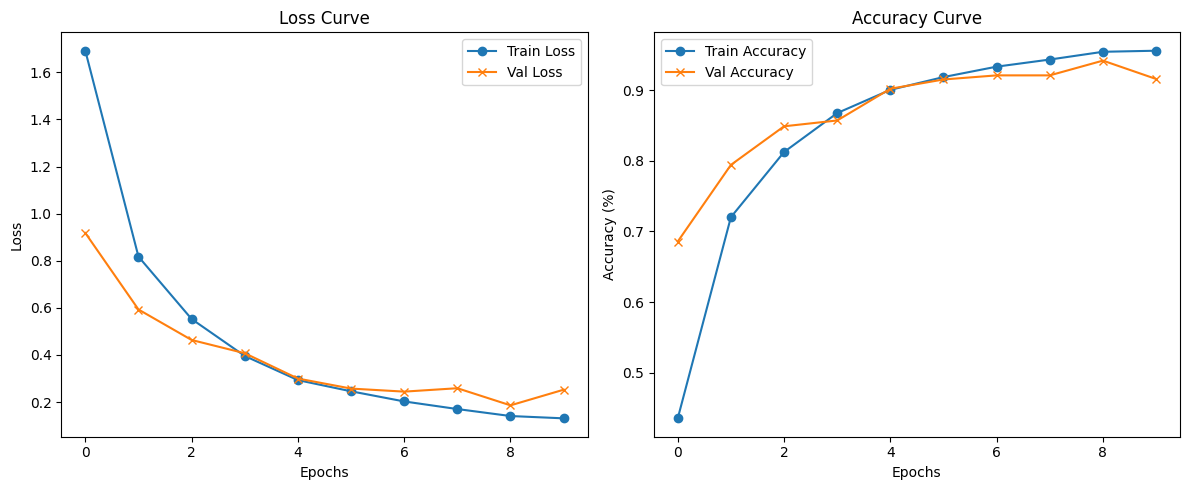

In [13]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history['val_acc'], label='Val Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


# Save CSV
bs = batch_size          # or any int like 64
lr = learning_rate       # e.g., 0.001
do = 0.5                 # if you're using dropout=0.5 in your model
pd.DataFrame(history).to_csv(f"history_fold{fold+1}.csv", index=False)


📊 Classification Report
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.84      0.90       200
                     Pepper__bell___healthy       0.97      0.98      0.98       302
                      Potato___Early_blight       0.97      0.98      0.98       189
                       Potato___Late_blight       0.97      0.90      0.93       188
                           Potato___healthy       0.96      0.81      0.88        31
                      Tomato_Bacterial_spot       0.97      0.96      0.96       441
                        Tomato_Early_blight       0.71      0.90      0.79       191
                         Tomato_Late_blight       0.93      0.89      0.91       340
                           Tomato_Leaf_Mold       0.97      0.90      0.93       186
                  Tomato_Septoria_leaf_spot       0.89      0.93      0.91       390
Tomato_Spider_mites_Two_spotted_spider_m

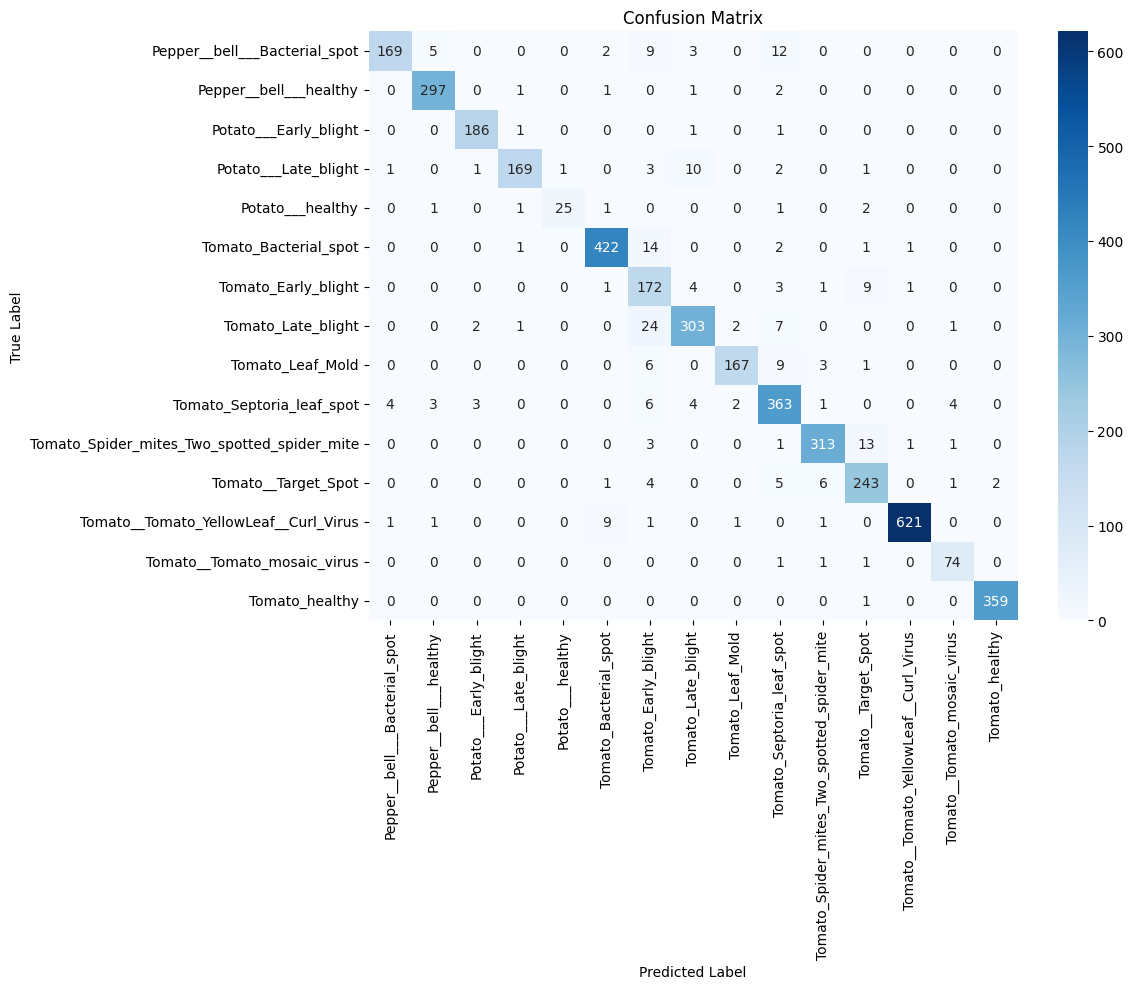

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


class_names = full_ds.classes

# 🟢 Collect predictions
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Classification Report
print("📊 Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names))

# 📌 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [15]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
torch.save(model.state_dict(), f"densenet_final_{timestamp}.pth")


In [16]:
best_val_acc = max(history['val_acc'])
best_val_loss = min(history['val_loss'])

results = []  # Definition of ResultArray

results.append({
    "batch_size": bs,
    "lr": lr,
    "dropout": do,
    "val_acc": best_val_acc,
    "val_loss": best_val_loss
})

results.append({
    "batch_size": bs,
    "lr": lr,
    "dropout": do,
    "val_acc": best_val_acc,  # capture from training loop
    "val_loss": best_val_loss
})

In [17]:
import pandas as pd
pd.DataFrame(results).to_csv("hyperparameter_results(DenseNet).csv", index=False)

In [18]:
#!pip install tensorboard


In [19]:
#%pip install tensorboard


In [20]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Inside training loop:
writer.add_scalar("Loss/train", train_loss, epoch)
writer.add_scalar("Loss/val", val_loss, epoch)
writer.add_scalar("Accuracy/val", val_acc, epoch)

# After training
writer.close()

In [35]:
# TRY THESE INSTEAD OF TRAINING AGAIN & AGAIN ....

In [36]:
#!pip install tensorflow opencv-python matplotlib
#!pip install opencv-contrib-python


In [37]:
#%pip install opencv-contrib-python


In [39]:
#!pip install torchcam


In [21]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader


# === CONFIG ===
MODEL_PATH = "alexnet_fold5_bs16_lr0.0001_do0.3.pth"
DATASET_DIR = r"D:\Internship(sujesh)\PlantVillage"
NUM_CLASSES = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
TEST_RATIO = 0.1
VAL_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === LOAD DATASET AND SPLIT ===
full_ds = ImageFolder(DATASET_DIR, transform=VAL_TRANSFORM)
test_size = int(TEST_RATIO * len(full_ds))
remaining_size = len(full_ds) - test_size
remaining_ds, test_ds = random_split(full_ds, [remaining_size, test_size],
                                     generator=torch.Generator().manual_seed(SEED))
test_indices = test_ds.indices
test_image_paths = [full_ds.samples[i][0] for i in test_indices]


# === ALEXNET MODEL ===
model = AlexNet(num_classes=num_classes)
model = model.to(device)




In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os, cv2, random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn

# === Define GradCAM Class (no changes needed here) ===
class GradCAM:
    def __init__(self, model, target_layer="layer5.2"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        target_module = dict(self.model.named_modules())[self.target_layer]
        target_module.register_forward_hook(forward_hook)
        target_module.register_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        x = x.to(self.device)
        output = self.model(x)
        # Get the predicted class index and confidence
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class_idx = torch.max(probabilities, 1)

        if class_idx is None:
            class_idx = predicted_class_idx.item()

        self.model.zero_grad()
        output[:, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        
        return cam, confidence.item()  # Return both the heatmap and the confidence

# === Visualization Function (no changes needed here) ===
def overlay_cam_on_image(heatmap, image_path, alpha=0.4):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    cam = heatmap.squeeze().detach().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = np.uint8(255 * cam)
    heatmap_colored = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    blended = cv2.addWeighted(heatmap_colored, alpha, image, 1 - alpha, 0)
    
    return blended

# === Preprocessing for test image ===
VAL_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assuming you have a pre-trained 'model' and 'test_image_paths' list
# You need to define these variables for the code to run
# Example:
# model = MyCustomModel() # Replace with your actual model
# test_image_paths = ["path/to/image1.jpg", "path/to/image2.jpg", ...]
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================================================================
# === Main Script: Apply GradCAM and Filter by Confidence (Adjusted Code) ===
# =========================================================================

# Define the output directory and ensure it exists
OUTPUT_DIR = "selected_gradcam_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Instantiate Grad-CAM generator
cam_generator = GradCAM(model, target_layer="layer5.2")

# Set a confidence threshold. Only images with a confidence higher than this will be saved.
CONFIDENCE_THRESHOLD = 0.95  # You can adjust this value (e.g., 0.90, 0.85, etc.)

saved_count = 0
for i, img_path in enumerate(test_image_paths):
    try:
        # Load and preprocess the image
        img = Image.open(img_path).convert("RGB")
        input_tensor = VAL_TRANSFORM(img).unsqueeze(0).to(cam_generator.device)

        # Generate Grad-CAM and get the confidence score
        heatmap, confidence = cam_generator(input_tensor)

        # Check if the confidence meets the threshold
        if confidence >= CONFIDENCE_THRESHOLD:
            # === Save the Grad-CAM visualization if it's "good" ===
            overlay = overlay_cam_on_image(heatmap, img_path)
            
            # Use the original image name to make the output file identifiable
            original_filename = os.path.basename(img_path)
            out_path = os.path.join(OUTPUT_DIR, f"conf-{confidence:.2f}_{original_filename}")
            
            # Convert color format and save the image
            cv2.imwrite(out_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            saved_count += 1
            print(f"✅ Saved high-confidence Grad-CAM for: {original_filename} (Confidence: {confidence:.2f})")
        else:
            print(f"❌ Skipped low-confidence image: {os.path.basename(img_path)} (Confidence: {confidence:.2f})")

    except Exception as e:
        print(f"❗ Could not process image {img_path}: {e}")
        continue

print(f"\n--- Process Complete ---")
print(f"Total images processed: {len(test_image_paths)}")
print(f"Total high-confidence images saved: {saved_count}")
print(f"Saved visualizations are located at: {OUTPUT_DIR}/")


: 

In [ ]:
import matplotlib.pyplot as plt

def show_gradcam_heatmap(heatmap, title="Grad-CAM Heatmap"):
    """
    Display Grad-CAM heatmap as a standalone image.
    Args:
        heatmap (torch.Tensor): Shape (1, 1, H, W) normalized between 0–1
    """
    cam = heatmap.squeeze().detach().cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(cam, cmap='jet')
    plt.colorbar(label='Activation Intensity')
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# === Usage ===
show_gradcam_heatmap(heatmap)



: 